<a href="https://colab.research.google.com/github/KWeatherwalks/DS-Unit-2-Linear-Models/blob/master/module2-regression-2/Kevin_Weatherwalks_LS_DS_212_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [x] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [x] Engineer at least two new features. (See below for explanation & ideas.)
- [x] Fit a linear regression model with at least two features.
- [x] Get the model's coefficients and intercept.
- [x] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [x] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [x] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [98]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

### Import libraries

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # for plotting

# for calculating model scores
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set facecolor for every plot
plt.rcParams['figure.facecolor'] = 'lightgray'

# 1. Wrangle Data

In [100]:
# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv',
                 parse_dates=['created'],
                 index_col='created')
assert df.shape == (49352, 33)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [101]:
df.head()

,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-24 07:54:24,1.5,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-06-12 12:19:27,1.0,2,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-17 03:26:41,1.0,1,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-18 02:22:02,1.0,1,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-28 01:32:41,1.0,4,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Feature Engineering
Let's combine the beds and baths to get total rooms to use as a feature in our linear model.

In [102]:
df['total_rooms'] = df['bedrooms'] + df['bathrooms']

#### IDEA: Use the distance from the most expensive apartment as a feature.
I'm guessing that we we are all aware of how real estate prices tend to cluster together. High price apartments are close to many amenities a city has to offer. So taking the highest price apartment as our locus might reveal something valuable for our predictive model.

**First** we will identify the latitude and longitude for the highest priced apartment.

In [103]:
df[df.price == df['price'].max()]

,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,total_rooms
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-13 02:29:37,2.5,3,CooperCooper.com :: Listing ID #6AA.6001; Acce...,West 23rd Street,40.7425,-73.9926,15500,60 West 23rd Street,low,1,1,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.5
2016-06-12 13:29:29,3.0,3,Breathtaking penthouse 3-bedroom 3-bat...,Horatio Street,40.7387,-74.0092,15500,110-114 Horatio Street,low,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0
2016-06-18 01:26:30,2.0,3,Must-see... over 1900 sq ft in this SPACIOUS 1...,West 87th Street,40.7889,-73.9755,15500,247 West 87th Street,low,0,1,0,1,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,5.0
2016-06-11 01:13:13,3.0,3,,East 92nd Street,40.7826,-73.9509,15500,205 East 92nd Street,low,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0
2016-06-12 11:01:57,3.0,3,,Horatio Street,40.7387,-74.0092,15500,110-114 Horatio Street,low,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0
2016-05-27 04:09:04,1.0,3,This apartment features a Bosch washer and dry...,210 West 72nd,40.7789,-73.9824,15500,210 West 72nd,low,1,1,1,1,1,1,0,1,1,0,1,1,1,0,1,1,0,1,0,0,0,0,0,1,4.0
2016-05-19 01:46:55,4.0,5,NaN,Central Park West,40.7909,-73.9655,15500,350 Central Park West,low,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.0
2016-05-12 05:49:02,2.0,2,Beautiful corner two bedroom in the heart of S...,Thompson St.,40.7239,-74.0036,15500,51 Thompson St.,low,1,0,1,0,1,1,1,0,1,0,1,1,1,1,0,1,0,1,1,0,1,0,0,0,4.0
2016-04-06 05:30:22,2.0,2,,Thompson Street,40.7240,-74.0035,15500,55 Thompson Street,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0


Oh, what's this?  
There is a problem though since there are multiple apartments with the maximum price in the dataset.  
We can do a couple things to remedy this. 
1. Pick one 
2. Take the mean latitude and mean longitude of all of them

### Option 1: Central Park West

Well, maybe it's really nice to live close to Central Park. So let's use the apartment located at Central Park West as our locus

In [104]:
mask = (df['price']==df['price'].max()) & (df['display_address']=='Central Park West')
locus_lat = float(df[mask]['latitude'])
locus_long = float(df[mask]['longitude'])

In [105]:
locus_lat, locus_long

(40.7909, -73.9655)

Let's create a function that will take a row from our dataframe and return the calculated distance to 350 Central Park West.  
Since we are looking at apartments that are fairly close to each other in terms of latitude and longitude, we'll simplify the calculation and use the Euclidean distance. That is $$distance = \sqrt{(x_1-x_0)^2 + (y_1 - y_0)^2}$$
where $(x_0,y_0)$ is the locus latitude and longitude and $(x_1,y_1)$ is the latitude and longitude of the apartment which we wish to calculate distance.

In [106]:
# Create function to apply to each row
def distance_from_locus(row):
  x = row['latitude']
  y = row['longitude']
  lat_diff = x - locus_lat
  long_diff = y - locus_long
  distance = np.sqrt(lat_diff**2 + long_diff**2)
  return distance

In [107]:
# Apply function to create new feature
df['distance_from_locus'] = df.apply(distance_from_locus, axis=1)

In [108]:
# Alternatively, we can apply this calculation directly using numpy and pandas broadcasting
df['distance_from_locus'] = np.sqrt((df['latitude'] - locus_lat)**2 + (df['longitude'] - locus_long)**2)

### Visualize target vs. features

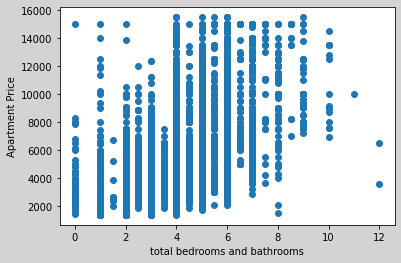

In [109]:
# Plot feature 1
plt.scatter(df['total_rooms'], df['price'])
plt.xlabel('total bedrooms and bathrooms')
plt.ylabel('Apartment Price')
plt.show()

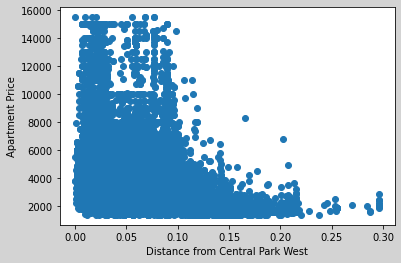

In [142]:
# Plot feature 2
plt.scatter(df['distance_from_locus'], df['price'])
plt.xlabel('Distance from Central Park West')
plt.ylabel('Apartment Price')
plt.show()

Well that doesn't look quite linear but let's see what how our model does.

# 2. Split Data

We're just about ready to split our data into training and testing sets.
But first, let's set up our `X` matrix and `y` vector.

In [111]:
X = df[['total_rooms','distance_from_locus']]
y = df['price']

Now we'll do our Train-Test split

In [112]:
# Use data from April & May 2016 to train. Use data from June 2016 to test.
train_mask = (df.index >= '2016-04') & (df.index < '2016-06')
test_mask = (df.index >= '2016-06') & (df.index < '2016-07')
X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

In [143]:
# Check that our sets have the right shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((31844, 2), (16973, 2), (31844,), (16973,))

# 3. Establish Baseline

In [114]:
# Save the mean and median to plot later
y_mean = y_train.mean()
y_median = y_train.median()

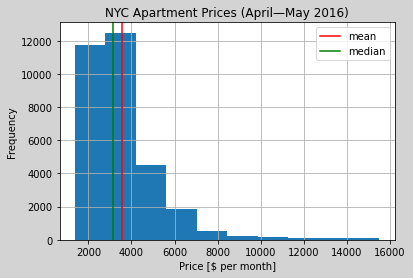

In [115]:
# Plot the distribution of apartment prices
fig, ax = plt.subplots()
fig.set_facecolor('lightgray')
y_train.hist()
plt.axvline(x=y_mean, color='red', label='mean')
plt.axvline(x=y_median, color='green', label='median')
plt.title('NYC Apartment Prices (April—May 2016)')
plt.xlabel('Price [$ per month]')
plt.ylabel('Frequency')
plt.legend();

In [150]:
# Use median as baseline since apartment prices have a right-skewed distribution
# So the median should be a better predictor than the mean
y_baseline = [y_train.median()]*len(y_train)
print('Median NYC apartment price: $', y_train.median())
print('Baseline MAE:', mean_absolute_error(y_baseline, y_train))
print('Baseline RMSE:', mean_squared_error(y_train, y_baseline, squared=False))
print('Baseline R^2:', r2_score(y_train, y_baseline))

Median NYC apartment price: $ 3150.0
Baseline MAE: 1138.5192186911192
Baseline RMSE: 1812.7788030244858
Baseline R^2: -0.05833723821249692


# 4. Build Model

In [117]:
from sklearn.linear_model import LinearRegression

# Create instance of model object
model = LinearRegression()

# Fit training data
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# 5. Check Metrics

In [118]:
print('Training MAE:\t', mean_absolute_error(model.predict(X_train), y_train))
print('Model MAE:\t', mean_absolute_error(model.predict(X_test), y_test))

Training MAE:	 892.9272312408636
Model MAE:	 905.9818842589352


In [119]:
# R-squared score
print('Training RMSE:\t', mean_squared_error(y_train, model.predict(X_train), squared=False))
print('Model RMSE:\t', mean_squared_error(y_test, model.predict(X_test), squared=False))

Training RMSE:	 1324.1002460218053
Model RMSE:	 1321.7656444001093


In [120]:
# R-squared score
print('Training R^2:\t', model.score(X_train, y_train))
print('Model R^2:\t', model.score(X_test, y_test))

Training R^2:	 0.43535409713419376
Model R^2:	 0.4378853076756638


# 6. Communicate Results

Our model does better than the baseline model and explains about 44% of the variance in apartment prices.

In [145]:
print(f'apartment price = {round(model.intercept_,3)} + ({round(model.coef_[0],3)})*total_rooms + ({round(model.coef_[1],3)})*distance_from_locus')

apartment price = 1696.555 + (811.148)*total_rooms + (-6295.46)*distance_from_locus


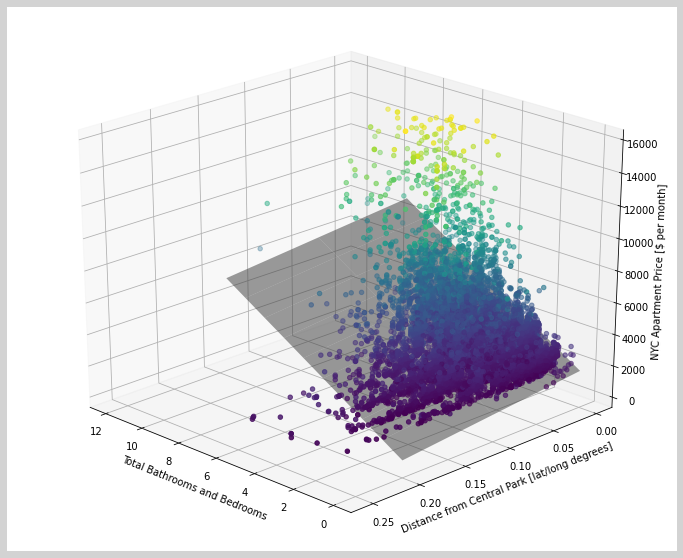

In [151]:
# Format the data for plotting
x_rooms = X_test['total_rooms']
y_distance = X_test['distance_from_locus']
z_price = y_test

# Create the data to plot the best-fit plane
(x_plane, y_plane) = np.meshgrid(np.arange(0, 10, 1), np.arange(0, 0.3, 0.1))
z_plane = model.intercept_ + model.coef_[0]*x_plane + model.coef_[1]*y_plane

# Import for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Initial the figure and axes objects
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')

# Plot the data: 2 features, 1 target
ax.scatter(xs=x_rooms, ys=y_distance, zs=z_price, zdir='z', 
           s=20, c=z_price, cmap=cm.viridis)

# Plot the best-fit plane
ax.plot_surface(x_plane, y_plane, z_plane, color='gray', alpha = 0.5)

# General figure/axes properties
ax.view_init(elev=25, azim=495)
ax.set_xlabel('Total Bathrooms and Bedrooms')
ax.set_ylabel('Distance from Central Park [lat/long degrees]')
ax.set_zlabel('NYC Apartment Price [$ per month]')


plt.show()

Based on Code from Canvas  
https://lambdaschool.instructure.com/courses/564/pages/objective-02-use-scikit-learn-to-fit-a-multiple-regression?module_item_id=527251